In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Source seeking simulations (distributed computing) -
"""
!python -V || python3 -V

Python 3.10.12


In [6]:
# If executed from Google Colab --------------------------------------------------------
# !git clone https://github.com/jesusBV20/source_seeking_distr.git
# !rsync -a source_seeking_distr/ .
# !rm -r source_seeking_distr

# If you want to use latex with matplotlib ---------------------------------------------
# !apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !pip install -y latex

In [2]:
import numpy as np
import os
import sys

from scipy.optimize import minimize

import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Scalar field functions
from sourceseeking_distr.scalar_field.sigma_common import SigmaField
from sourceseeking_distr.scalar_field.sigma_funcs import SigmaGauss, SigmaNonconvex, SigmaFract 

# Main utility functions used along the notebook
from sourceseeking_distr.toolbox.math_utils import XY_distrib, norm_2
from sourceseeking_distr.toolbox.basic_utils import createDir
from sourceseeking_distr.toolbox.plot_utils import vector2d, unicycle_patch

# --------------------------------------------------------------------------------------

# Create the output directory
OUTPUT_FOLDER = os.path.join("..", "output")
createDir(OUTPUT_FOLDER)

The directory '../output' already exists!


## Proposition 1 - Paper example figure 

In [25]:
def regpoly_formation(N,r,thetha0=0):
    """
    Function to generate a regular polygon distribution.
    """
    d_theta = 2*np.pi/N
    theta = []

    for i in range(N):
        if N == 2:
            theta.append(d_theta*i + thetha0)
        elif N%2 == 0:
            theta.append(d_theta*i + d_theta/2 + thetha0)
        else:
            theta.append(d_theta*i + d_theta/4 + thetha0)
    
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

class Proposition1:
    def __init__(self, P: np.ndarray, sigma_field: SigmaField):
        self.N = P.shape[0]
        self.P = P

        pc = np.sum(P, axis=0)/P.shape[0]
        self.X = P - pc
        self.D = np.max(np.linalg.norm(self.X, axis=1))

        self.sigma_field = sigma_field

        self.compute_lambda_min()
        self.data_dist = []
        self.delta_list = []
        self.data_ineq = []
        self.data_rate = []

    def compute_lambda_min(self):
        P = np.zeros((2,2))
        for i in range(self.N):
            P += self.X[i:i+1,:].T @ self.X[i:i+1,:]
        P /= self.N
        P_eig = np.linalg.eigvals(P)
        self.P_min = np.min(P_eig)

    def analyse_field(self, epsilons: list[float], debug=False):
        ep_min = epsilons[0]
        ep_max = epsilons[1]
    
        ps = np.linspace(self.sigma_field.mu[0] + ep_min, self.sigma_field.mu[0] + ep_max, 300)
        ps = [ps, ps*0 + self.sigma_field.mu[1]]

        grad_norms, hess_norms = [], []
        for x,y in zip(ps[0], ps[1]):
            grad = self.sigma_field.grad(np.array([x,y]))
            H = self.sigma_field.hessian(np.array([x,y]))
            grad_norms.append(np.linalg.norm(grad))
            hess_norms.append(norm_2(H))
        
        if debug:
            plt.plot(grad_norms)
            plt.show()
            plt.plot(hess_norms)
            plt.show()

        K_min = np.min(grad_norms)
        M = np.max(hess_norms)/2

        return K_min, M

    def compute_example(self, dist_range: list[float], delta_list: list[float], its=100):
        self.data_dist = np.linspace(dist_range[0], dist_range[1], its)
        self.delta_list = delta_list
        self.data_ineq = []
        self.data_rate = []

        for delta in delta_list:
            ineq_list = []
            rate_list = []
            for d in self.data_dist:
                K_min, M = self.analyse_field(epsilons = [d-delta/2, d+delta/2])
                
                ineq_list.append(self.P_min/self.N/self.D**2*K_min - M*self.D)
                rate_list.append(K_min/M)

            self.data_ineq.append(ineq_list)
            self.data_rate.append(rate_list)

        self.data_ineq = np.array(self.data_ineq).T
        self.data_rate = np.array(self.data_rate).T

    def plot(
            self, 
            dpi=100, 
            figsize=(14,8), 
            xlim=[-5,60], 
            ylim=[15,55],
            fontsize=12
            ):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        grid = plt.GridSpec(2, 4, hspace=0.2, wspace=1)
        ax = fig.add_subplot(grid[:, 0:2])
        ax_right1 = fig.add_subplot(grid[0, 2:4])
        ax_right2 = fig.add_subplot(grid[1, 2:4])

        thr = self.N*self.D**3/self.P_min

        # Axis configuration
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("X [L]")
        ax.set_ylabel("Y [L]")
        ax.set_aspect("equal")

        # Right axis configuration
        ax_right1.set_ylabel(r"$\frac{\lambda_{min} \{P(x)\}}{ND^2}K_\mathcal{S}^{min} - M_\mathcal{S} \, D$ [u/L]")
        ax_right1.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        ax_right1.yaxis.tick_right()
        ax_right1.grid(True)
        ax_right2.set_xlabel(r"$||p_c - p_\sigma||$ [L]")
        ax_right2.set_ylabel(r"$K_\mathcal{S}^{min} \,/\,M$ [L]")
        ax_right2.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        ax_right2.yaxis.tick_right()
        ax_right2.grid(True)

        # -- Notation plot --

        # Draw the scalar field
        dx, dy = abs(xlim[0] - xlim[1]), abs(ylim[0] - ylim[1])
        kw_field = {"xlim": dx, "ylim": dy, "n": 1000, "contour_levels": 15}
        self.sigma_field.draw(fig, ax, **kw_field)

        # Draw p_c and p_sigma
        pc = np.array([20, 0])

        ax.plot(pc[0], pc[1], "+k") 
        vector2d(ax, [0,0], pc-np.array([1, 0]), lw = 2, hw=0.5, hl=0.5, zorder=2)
        ax.text(-2, 1, r"$p_\sigma$", fontsize=fontsize, zorder=3)
        ax.text(pc[0]/2, pc[1]+1, r"$p_c$", fontsize=fontsize, zorder=3)

        # Draw the subset S
        delta = 2.5
        set_patch = plt.Circle(pc, delta, color="gray")
        set_patch.set_alpha(0.5)
        ax.add_patch(set_patch)

        h = - (delta + 1.5)
        vector2d(ax, pc + np.array([0,h]), np.array([-delta,0]), lw = 1, hw=0.25, hl=0.25, zorder=2)
        vector2d(ax, pc + np.array([0,h]), np.array([ delta,0]), lw = 1, hw=0.25, hl=0.25, zorder=2)
        ax.text(pc[0]-0.5, pc[1]+h-1.5, r"$\delta$", fontsize=fontsize, zorder=3)
        ax.text(pc[0]+0.5, pc[1]+0.5, r"$\mathcal{S}$", fontsize=fontsize, zorder=3)
        
        # -- Numerical simulation plots --
        ax_right1.axhline(0, color="k", ls="--", lw=1)
        ax_right2.axhline(thr, color="k", ls="--", lw=1)
        ax_right2.text(-1,thr+3, r"$\frac{ND^3}{\lambda_{min}\{P(x)\}}$", fontsize=fontsize, zorder=3)

        for i in range(len(self.delta_list)):
            delta = self.delta_list[i]
            ax_right1.plot(self.data_dist, self.data_ineq[:,i], label=r"$\delta$ = {:.1f}".format(delta))
            ax_right2.plot(self.data_dist, self.data_rate[:,i])
            
        ax_right1.legend(fancybox=True, prop={"size": 10})
        
        # -> Show the plot <-
        ax.grid(True)
        plt.show()

In [26]:
## Parameters #####
N = 7
p = regpoly_formation(N,1)
# p = XY_distrib(N, pc, np.array([2,3]))
epsilons = [10,20]

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
mu = [0,0]
max_int = 1000
dev = 15

sigma_field = SigmaGauss(mu=mu, max_intensity=max_int, dev=dev)

In [27]:
prop1 = Proposition1(p, sigma_field)
prop1.compute_example(dist_range=[0,40], delta_list=[1.5,3,5], its=50)

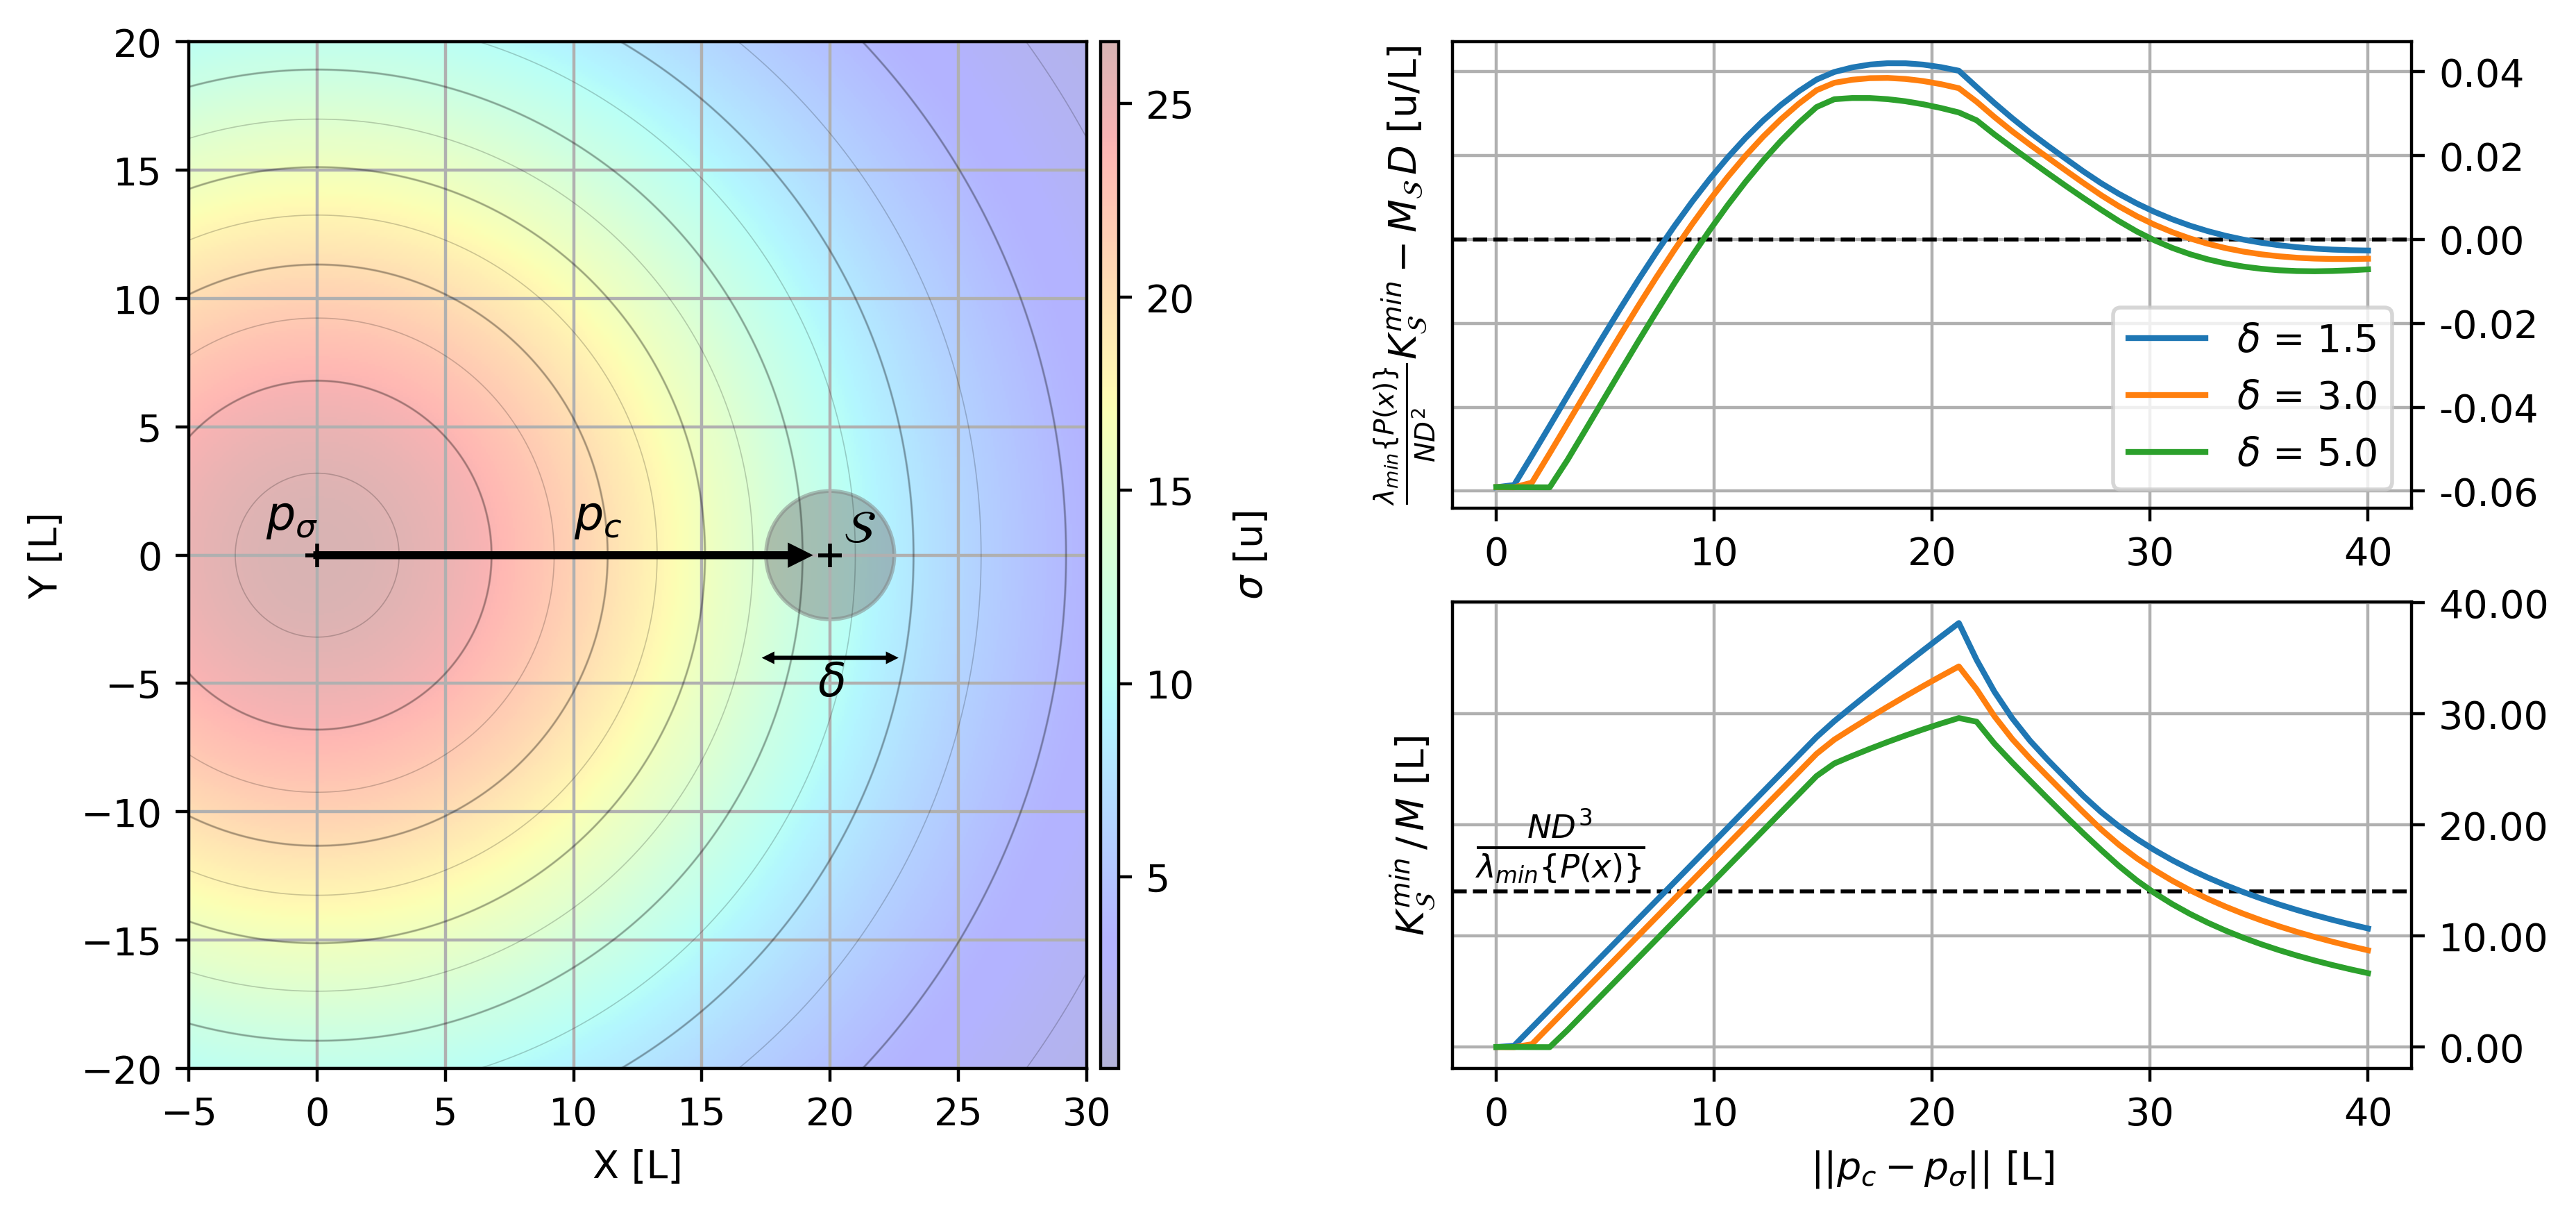

In [28]:
prop1.plot(dpi=400, figsize=(13*0.8,6*0.8), xlim=[-5,30], ylim=[-20,20])